In [2]:
# Let's do our imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from glob import glob
%matplotlib inline

In [29]:
# We'll define root mean squared log error & root mean squared error up here
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [5]:
# Now we have to get our data. First Step was to download to the local system.
# Now let's get it into the notebook
# Kind of clunky, but this works for me: see what your cwd is
import os
rect = os.getcwd()
print(rect)

C:\Users\Raul\GitHub\DS-Unit-2-Applied-Modeling\module1-log-linear-regression


In [6]:
# Then change your directory to wherever you have your data
os.chdir(r"C:\Users\Raul\GitHub\caterpillar")

rect = os.getcwd()
print(rect)

C:\Users\Raul\GitHub\caterpillar


In [35]:
# Use that nice code block that Alex used to take a look at the csv's
for path in glob('data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

data\bill_of_materials.csv (21198, 17)
data\components.csv (2048, 3)
data\comp_adaptor.csv (25, 20)
data\comp_boss.csv (147, 15)
data\comp_elbow.csv (178, 16)
data\comp_float.csv (16, 7)
data\comp_hfl.csv (6, 9)
data\comp_nut.csv (65, 11)
data\comp_other.csv (1001, 3)
data\comp_sleeve.csv (50, 10)
data\comp_straight.csv (361, 12)
data\comp_tee.csv (4, 14)
data\comp_threaded.csv (194, 32)
data\sample_submission.csv (30235, 2)
data\specs.csv (21198, 11)
data\test_set.csv (30235, 8)
data\train_set.csv (30213, 8)
data\tube.csv (21198, 16)
data\tube_end_form.csv (27, 2)
data\type_component.csv (29, 2)
data\type_connection.csv (14, 2)
data\type_end_form.csv (8, 2)


In [11]:
# Now let's import train and test csv's
trainval = pd.read_csv('data/train_set.csv')
test = pd.read_csv('data/test_set.csv')

trainval.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [12]:
test.head(10)

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25
5,6,TA-00001,S-0066,2013-06-23,0,0,Yes,50
6,7,TA-00001,S-0066,2013-06-23,0,0,Yes,100
7,8,TA-00001,S-0066,2013-06-23,0,0,Yes,250
8,9,TA-00003,S-0066,2013-07-07,0,0,Yes,1
9,10,TA-00003,S-0066,2013-07-07,0,0,Yes,2


In [14]:
# We saw during lecture that the quote date would not be a suitable attribute to do a train test split
# So we're going to use tube_assembly_id
trainval_assemblies = trainval['tube_assembly_id'].unique()
test_assemblies = test['tube_assembly_id'].unique()

set(trainval_assemblies) & set(test_assemblies)

train_assemblies, val_assemblies = train_test_split(trainval_assemblies, random_state=42)

len(trainval_assemblies), len(train_assemblies), len(val_assemblies), len(test_assemblies)

(8855, 6641, 2214, 8856)

In [15]:
# Now we use our arrays of assemblies to split our dataframe
train = trainval[trainval['tube_assembly_id'].isin(train_assemblies)]
val = trainval[trainval['tube_assembly_id'].isin(val_assemblies)]

train.shape, val.shape, trainval.shape

((22628, 8), (7585, 8), (30213, 8))

In [17]:
# Ok, let's choose some features
train.head(10)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983
10,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596
11,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539
12,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331
13,TA-00004,S-0066,2013-07-07,0,0,Yes,50,3.291176
14,TA-00004,S-0066,2013-07-07,0,0,Yes,100,3.149291
15,TA-00004,S-0066,2013-07-07,0,0,Yes,250,3.065829
16,TA-00005,S-0066,2013-09-01,0,0,Yes,1,28.374220
17,TA-00005,S-0066,2013-09-01,0,0,Yes,2,16.514303


In [18]:
def organize(X):
    X = X.copy()
    
    # We'll create a list for duplicate and meaningless columns
    duplicates =[]
    meaningless = []
    
    # Let's pull month and year out of quote date
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
        
    # Now we can add quote_date & tube_assembly_id
    meaningless = meaningless + ['quote_date', 'tube_assembly_id']
    
    todrop = duplicates + meaningless
    X = X.drop(columns=todrop)
    
    return X

trainorg = organize(train)
valorg = organize(val)

In [21]:
target = ['cost']

features = trainorg.columns.drop(target)
print(feats.tolist())

['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [24]:
xtrain = trainorg[features]
xval = valorg[features]
ytrain = trainorg[target]
ytrainlog = np.log1p(ytrain)
yval = valorg[target]
yvallog = np.log1p(yval)

In [32]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(xtrain, ytrainlog)
ypredlog = pipeline.predict(xval)
rmse(yvallog, ypredlog)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.3950176959701

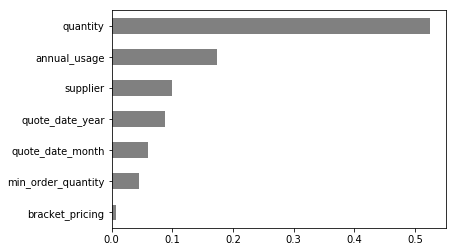

In [33]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, xtrain.columns)

importances.sort_values().plot.barh(color='grey');

In [37]:
# We'll use quantity for sure, and prob annual_usage
# Let's look at our other dataframes
for path in glob('data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
        print(path, df.shape)
        print(df.columns.tolist(), '\n')

data\bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

data\sample_submission.csv (30235, 2)
['id', 'cost'] 

data\specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'spec10'] 

data\test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

data\train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

data\tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 

In [39]:
tube = pd.read_csv('data/tube.csv')
tube.describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


In [40]:
tube.describe(exclude='number')

,tube_assembly_id,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x
count,21198,20919,21198,21198,21198,21198,21198,21198
unique,21198,19,2,2,2,2,25,27
top,TA-01168,SP-0029,N,N,N,N,EF-003,EF-003
freq,1,11488,20118,18015,20377,18493,11388,10863


In [78]:
# Ok, now let's take a look at bill_of_material
billmat = pd.read_csv('data/bill_of_materials.csv')
billmat.describe()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
count,19149.000000,14786.000000,4798.000000,608.000000,92.000000,26.000000,7.0,1.0
mean,1.559873,1.526106,1.020634,1.027961,1.032609,1.153846,1.0,1.0
std,0.507444,0.510851,0.160100,0.209041,0.178583,0.367946,0.0,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
75%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
max,6.000000,6.000000,4.000000,4.000000,2.000000,2.000000,1.0,1.0


In [80]:
numcols = billmat.select_dtypes(include='number').columns.tolist()

In [47]:
billmat.describe(exclude='number')

,tube_assembly_id,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8
count,21198,19149,14786,4791,607,92,26,7,1
unique,21198,1079,834,509,204,62,19,4,1
top,TA-01168,C-1621,C-1628,C-1641,C-1660,C-0872,C-0378,C-1019,C-1981
freq,1,2043,1959,421,62,10,3,3,1


In [79]:
objcols = billmat.select_dtypes(exclude='number').columns.tolist()

In [77]:

billmat[numcols] = billmat[numcols].fillna(0)
billmat[objcols] = billmat[objcols].replace(np.nan, 'null', regex=True)
billmat.isna().sum()

tube_assembly_id    0
component_id_1      0
quantity_1          0
component_id_2      0
quantity_2          0
component_id_3      0
quantity_3          0
component_id_4      0
quantity_4          0
component_id_5      0
quantity_5          0
component_id_6      0
quantity_6          0
component_id_7      0
quantity_7          0
component_id_8      0
quantity_8          0
dtype: int64

In [88]:
# Now we'll reconfigure organize to also merge the tube and billmat dataframes

def organize(X):
    X = X.copy()
    
    # We'll create a list for duplicate and meaningless columns
    duplicates =[]
    meaningless = []
    
    # Let's pull month and year out of quote date
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    
    # Let's merge the tube dataframe
    tube = pd.read_csv('data/tube.csv')
    X = X.merge(tube, how='left')
    
    billmat = pd.read_csv('data/bill_of_materials.csv')
    billmat[numcols] = billmat[numcols].fillna(0)
    billmat[objcols] = billmat[objcols].replace(np.nan, 'null', regex=True)
    X = X.merge(billmat, how='left')

    
    # Now we can add quote_date & tube_assembly_id
    meaningless = meaningless + ['quote_date', 'tube_assembly_id']
    
    todrop = duplicates + meaningless
    X = X.drop(columns=todrop)
    
    return X

trainorg = organize(train)
valorg = organize(val)

In [89]:
trainorg.shape, valorg.shape

((22628, 39), (7585, 39))

In [90]:
trainorg.head(10)

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,quote_date_year,quote_date_month,material_id,diameter,...,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,S-0066,0,0,Yes,1,21.972702,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
1,S-0066,0,0,Yes,2,12.407983,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
2,S-0066,0,0,Yes,5,6.668596,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
3,S-0066,0,0,Yes,10,4.754539,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
4,S-0066,0,0,Yes,25,3.608331,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
5,S-0066,0,0,Yes,50,3.291176,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
6,S-0066,0,0,Yes,100,3.149291,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
7,S-0066,0,0,Yes,250,3.065829,2013,7,SP-0019,6.35,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
8,S-0066,0,0,Yes,1,28.374220,2013,9,SP-0029,19.05,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0
9,S-0066,0,0,Yes,2,16.514303,2013,9,SP-0029,19.05,...,null,0.0,null,0.0,null,0.0,null,0.0,null,0.0


In [91]:
target = ['cost']

features = trainorg.columns.drop(target)
print(features.tolist())

['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8']


In [99]:
feats = ['annual_usage', 'quantity', 'supplier',
         'diameter', 'length', 'wall', 'num_bends',
         'quantity_1', 'quantity_2', 'quantity_3', 'quantity_4', 'quantity_5']

xtrain = trainorg[feats]
xval = valorg[feats]
ytrain = trainorg[target]
ytrainlog = np.log1p(ytrain)
yval = valorg[target]
yvallog = np.log1p(yval)

In [100]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(xtrain, ytrainlog)
ypredlog = pipeline.predict(xval)
rmse(yvallog, ypredlog)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.3629463621878714

In [108]:
testorg = organize(test)
xtest = testorg[feats]

ypredlog = pipeline.predict(xtest)
ypred = np.expm1(ypredlog)

sample_submission = pd.read_csv('data/sample_submission.csv')
submission = sample_submission.copy()
submission['cost'] = ypred
submission.to_csv('submission-01.csv', index=False)